In [1]:
run_gridsearch = True,
skip_best_model_validation = False,
skip_best_model_test = False
verbose = False
GPU_SETTING = -1
NUM_ENSEMBLES = 5
hyperparam_csv_file = "calpella_daily_hyperparams.csv"

In [2]:
hyperparam_space = {
    "hidden_size": [32, 64],
    "seq_length": [168],
    "num_layers": [1],
    "epochs": [1],
    "batch_size": [64],
    "schedule_pairs": [
        ((0.5, 0.25), (0.01, 0.005, 0.001))
    ]
}

In [3]:
import sys
import os
import itertools
import pandas as pd

In [4]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['..\\..\\..\\..\\UCB-USACE-LSTMs', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\python313.zip', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\DLLs', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project', '', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\win32', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\Pythonwin']


In [5]:
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (combinedPlot, fancyCombinedPlot, combinedPlotFromDf, fancyCombinedPlotFromDf, fractional_multi_lr)
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

target_path = os.path.join(library_path, 'UCB_training', 'models', 'calpella_all')

if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("calpella")) 
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\calpella_all
Train Basin File Exists: True


In [7]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("calpella_gage_nlayer.yaml")
path_to_physics_data = Path(library_path + "/russian_river_data/Calpella_daily_shift.csv")

In [8]:
features_with_physics = [
    #from hourly
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    #from new capella.csv
    'Capella Gage FLOW',
    'EF Russian 20 ET-POTENTIAL',
    'EF Russian 20 FLOW',
    'EF Russian 20 FLOW-BASE',
    'EF Russian 20 INFILTRATION',
    'EF Russian 20 PERC-SOIL',
    'EF Russian 20 SATURATION FRACTION',
    #    'Lake Mendocino Storage',
]

In [9]:
no_physics_results = []
physics_results = []

In [10]:
from datetime import datetime
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

Start time: 2025-06-19 01:14:18


C:\Users\arman\AppData\Local\Temp\ipykernel_30576\901109023.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


In [11]:
hyperparam_names = []
for i, hp in enumerate(hyperparam_space.keys()):
    hyperparam_names.append(hp)

total_iters = 1
for name in hyperparam_names:
    total_iters *= len(hyperparam_space[name])

if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] != "seq_length_1D" or hyperparam_names[j] != "seq_length_1H":
                hp_run[hyperparam_names[j]] = combinations[j]
                j += 1
            else:
                hp_run["seq_length"] = {"1D": combinations[j], "1H": combinations[j + 1]}
                j += 2

        if verbose:
            print(f"\nNoPhysics: {hp_run}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,  
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        
        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] == "learning_rate":
                row_data[hyperparam_names[j]] = str(combinations[j])
            else:
                row_data[hyperparam_names[j]] = combinations[j]
            j += 1
        for k, v in metrics_dict.items():
            row_data[k] = v
        
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Grid-Search: 100%|############| 2/2 [00:11<00:00,  5.59s/it]


In [12]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):    
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", ncols=60, 
        ascii=True):

        if "schedule_pairs" in hyperparam_names:
            (f1, f2), (lr1, lr2, lr3) = combinations[hyperparam_names.index("schedule_pairs")]

            fractions = [f1, f2]
            lr_list = [lr1, lr2, lr3]


            lr_dict = fractional_multi_lr(
                epochs=combinations[hyperparam_names.index("epochs")],
                fractions=fractions,
                lrs=lr_list,
                round_up=True)


        hp_run = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] != "seq_length_1D" or hyperparam_names[j] != "seq_length_1H":
                hp_run[hyperparam_names[j]] = combinations[j]
                j += 1
            else:
                hp_run["seq_length"] = {"1D": combinations[j], "1H": combinations[j + 1]}
                j += 2
        if verbose:
            print(f"\nPhysics: {hp_run}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()

        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            if hyperparam_names[j] == "learning_rate":
                row_data[hyperparam_names[j]] = str(combinations[j])
            else:
                row_data[hyperparam_names[j]] = combinations[j]
            j += 1

        for k, v in metrics_dict.items():
            row_data[k] = v
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping grid search!")

Grid-Search: 100%|############| 2/2 [00:05<00:00,  2.76s/it]


In [13]:
if run_gridsearch:
    print(df_no_physics.iloc[0:4])
    df_no_physics.to_csv("calpella_daily_no_physics_gridsearch.csv", index=False)

   hidden_size  seq_length  num_layers  epochs  batch_size  \
0           32         168           1       1          64   
1           64         168           1       1          64   

                        schedule_pairs       NSE           MSE        RMSE  \
0  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.536636  79379.976562  281.744524   
1  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.500435  85581.632812  292.543386   

        KGE  Alpha-NSE  Beta-KGE  Beta-NSE  Pearson-r        FHV        FMS  \
0  0.419626   0.495442  0.778013 -0.169833   0.818402 -60.257442 -13.676257   
1  0.330250   0.473387  0.611018 -0.297594   0.858802 -58.308441   7.763486   

          FLV  Peak-Timing  Peak-MAPE  
0 -141.729431          0.4  74.412743  
1  -13.540657          0.4  73.360504  


In [14]:
if run_gridsearch:
    print(df_physics.iloc[0:4])
    df_physics.to_csv("calpella_daily_physics_gridsearch.csv", index=False)

   hidden_size  seq_length  num_layers  epochs  batch_size  \
0           64         168           1       1          64   
1           32         168           1       1          64   

                        schedule_pairs       NSE           MSE        RMSE  \
0  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.748553  43075.980469  207.547538   
1  ((0.5, 0.25), (0.01, 0.005, 0.001))  0.683431  54232.191406  232.878061   

        KGE  Alpha-NSE  Beta-KGE  Beta-NSE  Pearson-r        FHV        FMS  \
0  0.670155   0.700812  0.918993 -0.061975   0.887208 -34.226505 -25.505209   
1  0.594157   0.630976  0.903498 -0.073830   0.861374 -45.410378 -18.478355   

         FLV  Peak-Timing  Peak-MAPE  
0  58.503479          0.6  53.669403  
1   2.662847          0.6  67.240799  


In [15]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()


    best_no_physics_params = {}
    j = 0
    while j < len(hyperparam_names):
        if hyperparam_names[j] == "output_dropout":
            best_no_physics_params[hyperparam_names[j]] = float(best_no_phys[hyperparam_names[j]])
            j += 1
        elif hyperparam_names[j] == "learning_rate":
            best_no_physics_params[hyperparam_names[j]] = eval(str(best_no_phys[hyperparam_names[j]]))
            j += 1
        elif hyperparam_names[j] == "seq_length_1D" or hyperparam_names[j] == "seq_length_1H":
            best_no_physics_params["seq_length"] = {"1D": int(best_no_phys[hyperparam_names[j]]), "1H": int(best_no_phys[hyperparam_names[j + 1]])}
            j += 2
        elif hyperparam_names[j] == "schedule_pairs":
            j += 1
            continue
        else:
            best_no_physics_params[hyperparam_names[j]] = int(best_no_phys[hyperparam_names[j]])
            j += 1
    
    best_physics_params = {}
    j = 0
    while j < len(hyperparam_names):
        if hyperparam_names[j] == "output_dropout":
            best_physics_params[hyperparam_names[j]] = float(best_phys[hyperparam_names[j]])
            j += 1
        elif hyperparam_names[j] == "learning_rate":
            best_physics_params[hyperparam_names[j]] = eval(str(best_phys[hyperparam_names[j]]))
            j += 1
        elif hyperparam_names[j] == "seq_length_1D" or hyperparam_names[j] == "seq_length_1H":
            best_physics_params["seq_length"] = {"1D": int(best_phys[hyperparam_names[j]]), "1H": int(best_phys[hyperparam_names[j + 1]])}
            j += 2
        elif hyperparam_names[j] == "schedule_pairs":
            j += 1
            continue
        else:
            best_physics_params[hyperparam_names[j]] = int(best_phys[hyperparam_names[j]])
            j += 1

    print("Loaded best hyperparams from CSV:")
    print("Best NO-PHYS:", best_no_physics_params)
    print("Best PHYS:", best_physics_params)
else:
    print(f"Error: {hyperparam_csv_file} not found. Did you run gridsearch?")

Loaded best hyperparams from CSV:
Best NO-PHYS: {'hidden_size': 32, 'seq_length': 168, 'num_layers': 1, 'epochs': 1, 'batch_size': 64}
Best PHYS: {'hidden_size': 64, 'seq_length': 168, 'num_layers': 1, 'epochs': 1, 'batch_size': 64}


### Re-run validation with best hyperparameters

In [16]:
if not skip_best_model_validation:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING
    )
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

In [17]:
if not skip_best_model_validation:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING
    )
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

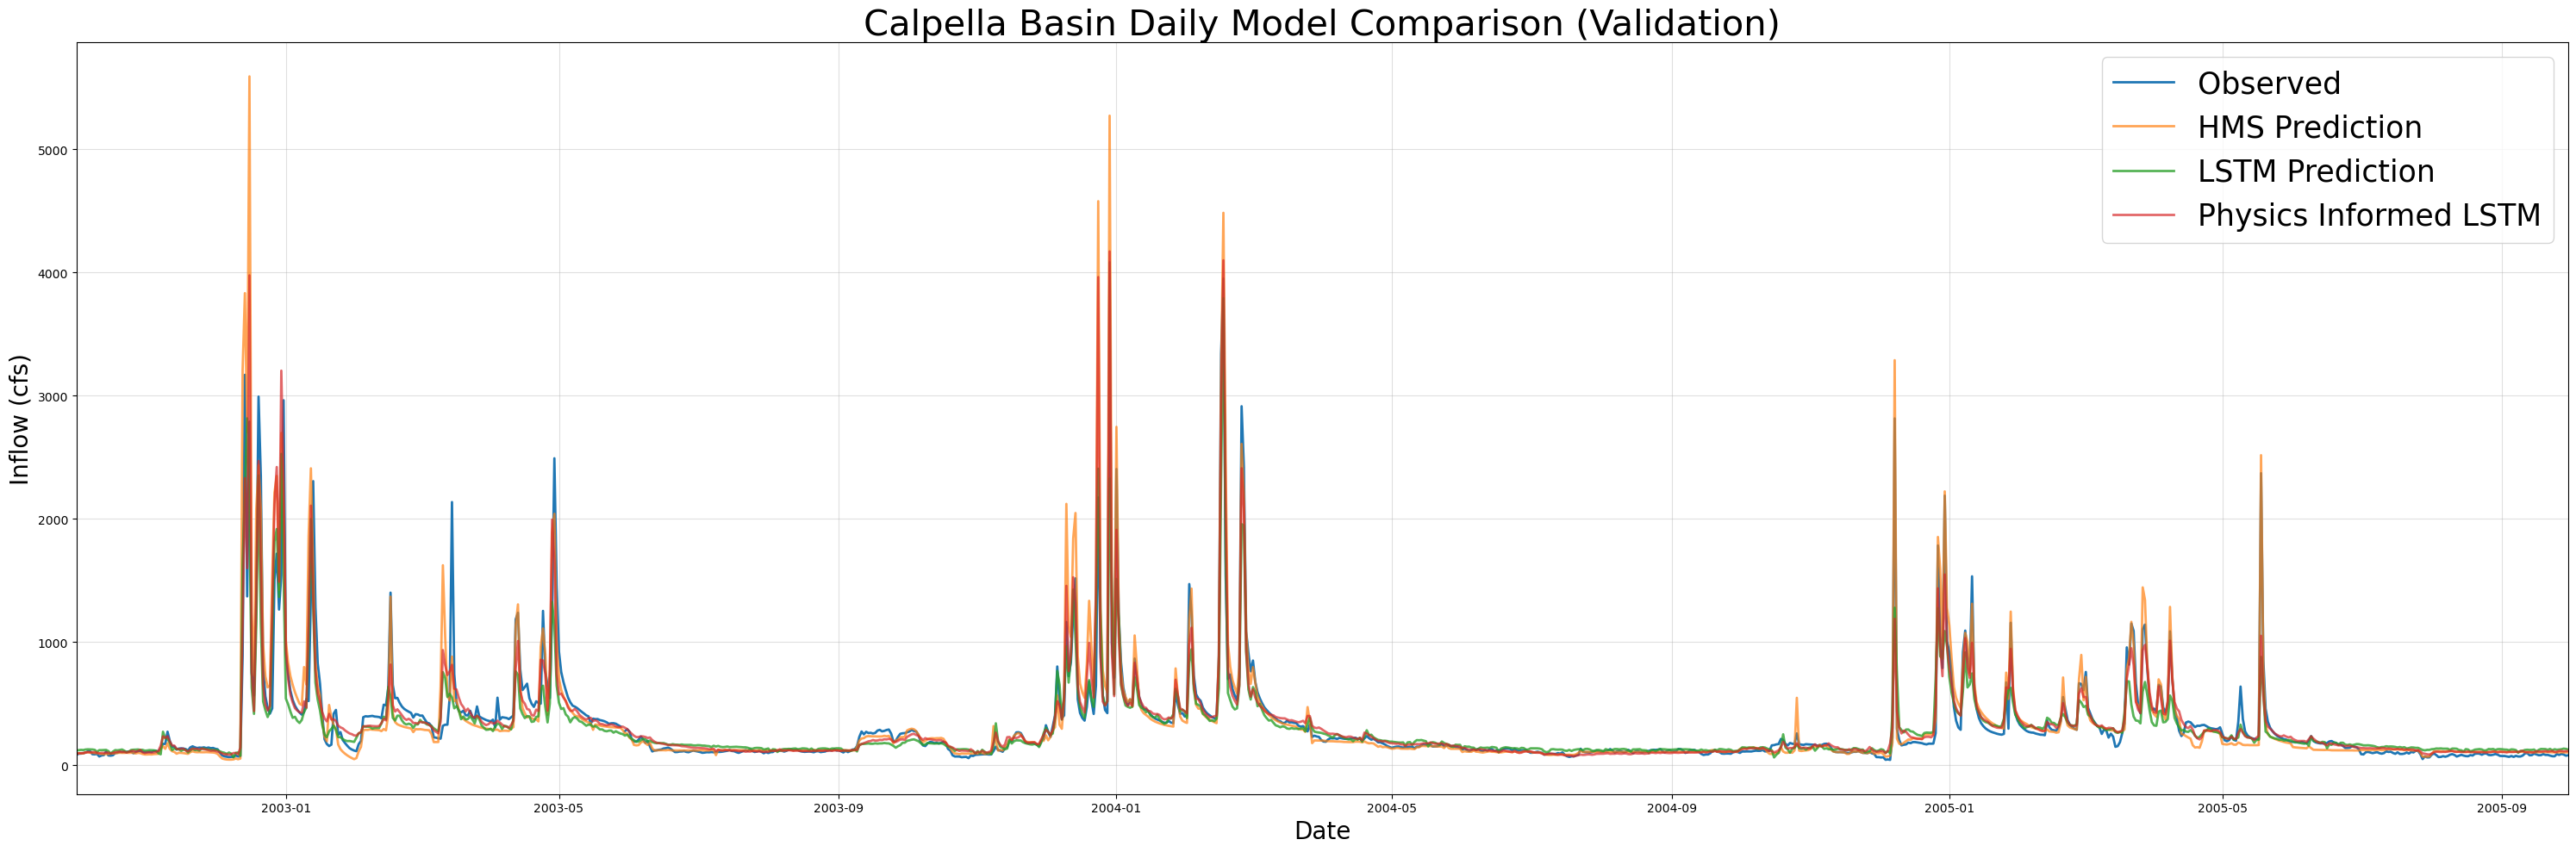

In [18]:
if not skip_best_model_validation:
    combinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title="Calpella Basin Daily Model Comparison (Validation)",
        fName="calpella_daily_val_metrics.csv",
        plot_filename="calpella_daily_val_model_comparison.png",
        timeseries_filename ="calpella_daily_val_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("calpella_daily_val_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Calpella Basin Daily Model Comparison (Validation)", fName="calpella_daily_val_metrics.csv")

In [19]:
if not skip_best_model_validation:
    fancyCombinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,  
        title='Calpella Basin Daily Model Comparison (Validation)',
        fName="calpella_daily_val_metrics.csv",
        timeseries_filename ="calpella_daily_val_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(combined_df, title='Calpella Basin Daily Model Comparison (Validation)', fName="calpella_daily_val_metrics.csv")

In [20]:
if skip_best_model_validation:
    test_metrics = pd.read_csv("calpella_daily_val_metrics.csv", index_col=0)
    print(test_metrics)

                      HMS          LSTM  Physics_Informed_LSTM
NSE              0.749142      0.783199               0.842304
MSE          42975.101681  37140.578079           27015.260288
RMSE           207.304370    192.718910             164.363196
KGE              0.757372      0.732359               0.908430
Alpha-NSE        1.223944      0.765309               0.958047
Beta-KGE         1.045560      0.923468               1.001475
Beta-NSE         0.034856     -0.058551               0.001128
Pearson-r        0.918504      0.896583               0.918618
FHV             19.067591    -21.543534              -3.706758
FMS             -9.037004    -19.379989              -4.203335
FLV             -1.647186     14.927489              48.923365
Peak-Timing      0.000000      0.400000               0.200000
Peak-MAPE       18.226079     48.983844              35.242072
PBIAS           -4.555977      7.653167              -0.147474


### Re-run testing with best hyperparameters

[UCB Trainer] Using CPU (unhandled gpu=-1).
2025-06-18 18:14:38,311: Logging to c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\calpella_all\runs\testing_run_1806_181438\output.log initialized.
2025-06-18 18:14:38,312: ### Folder structure created at c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\calpella_all\runs\testing_run_1806_181438
2025-06-18 18:14:38,313: ### Run configurations for testing_run
2025-06-18 18:14:38,314: experiment_name: testing_run
2025-06-18 18:14:38,315: train_basin_file: calpella
2025-06-18 18:14:38,316: validation_basin_file: calpella
2025-06-18 18:14:38,317: test_basin_file: calpella
2025-06-18 18:14:38,319: train_start_date: 1994-10-01 00:00:00
2025-06-18 18:14:38,320: train_end_date: 2005-09-30 00:00:00
2025-06-18 18:14:38,321: validation_start_date: 2002-10-01 00:00:00
2025-06-18 18:14:38,322: validation_end_date: 2005-09-30 00:00:00
2025-06-18 18:14:38,324: test_start_date: 2005-10-01 

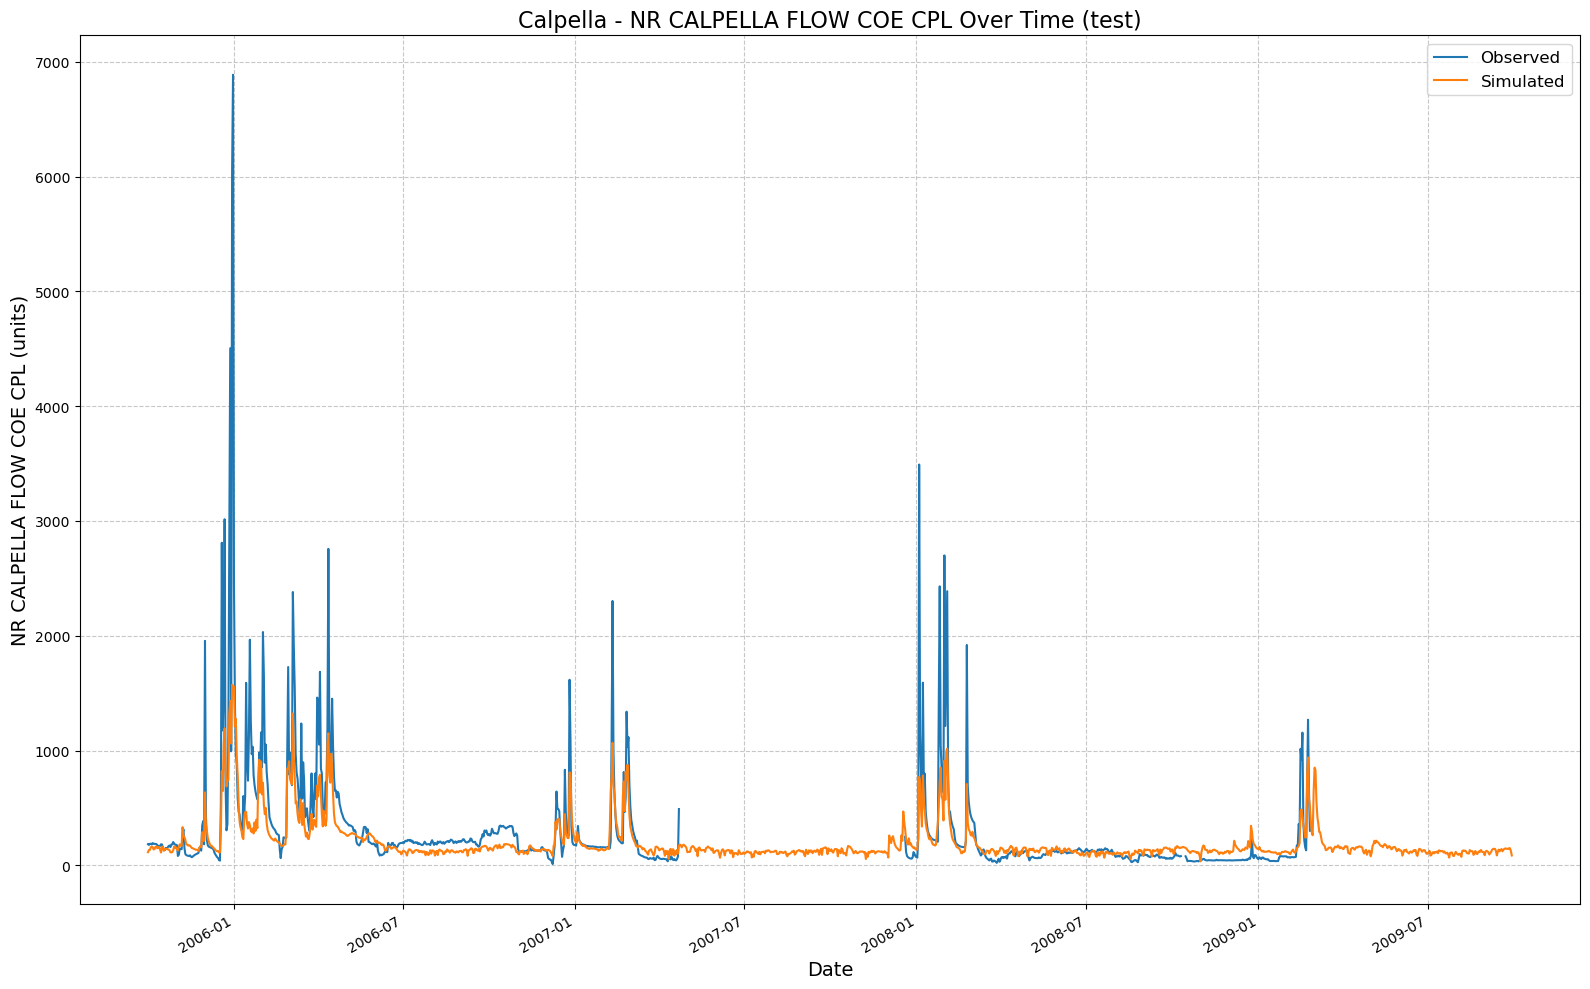

In [21]:
if not skip_best_model_test:
    lstmNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True,  
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
    )
    
    lstmNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = lstmNoPhysicsExtBest.results('test')
    no_physics_test_metrics

[UCB Trainer] Using CPU (unhandled gpu=-1).
2025-06-18 18:14:42,008: Logging to c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\calpella_all\runs\testing_run_1806_181442\output.log initialized.
2025-06-18 18:14:42,009: ### Folder structure created at c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-LSTMs\UCB_training\models\calpella_all\runs\testing_run_1806_181442
2025-06-18 18:14:42,010: ### Run configurations for testing_run
2025-06-18 18:14:42,011: experiment_name: testing_run
2025-06-18 18:14:42,032: train_basin_file: calpella
2025-06-18 18:14:42,033: validation_basin_file: calpella
2025-06-18 18:14:42,034: test_basin_file: calpella
2025-06-18 18:14:42,036: train_start_date: 1994-10-01 00:00:00
2025-06-18 18:14:42,036: train_end_date: 2005-09-30 00:00:00
2025-06-18 18:14:42,037: validation_start_date: 2002-10-01 00:00:00
2025-06-18 18:14:42,038: validation_end_date: 2005-09-30 00:00:00
2025-06-18 18:14:42,041: test_start_date: 2005-10-01 

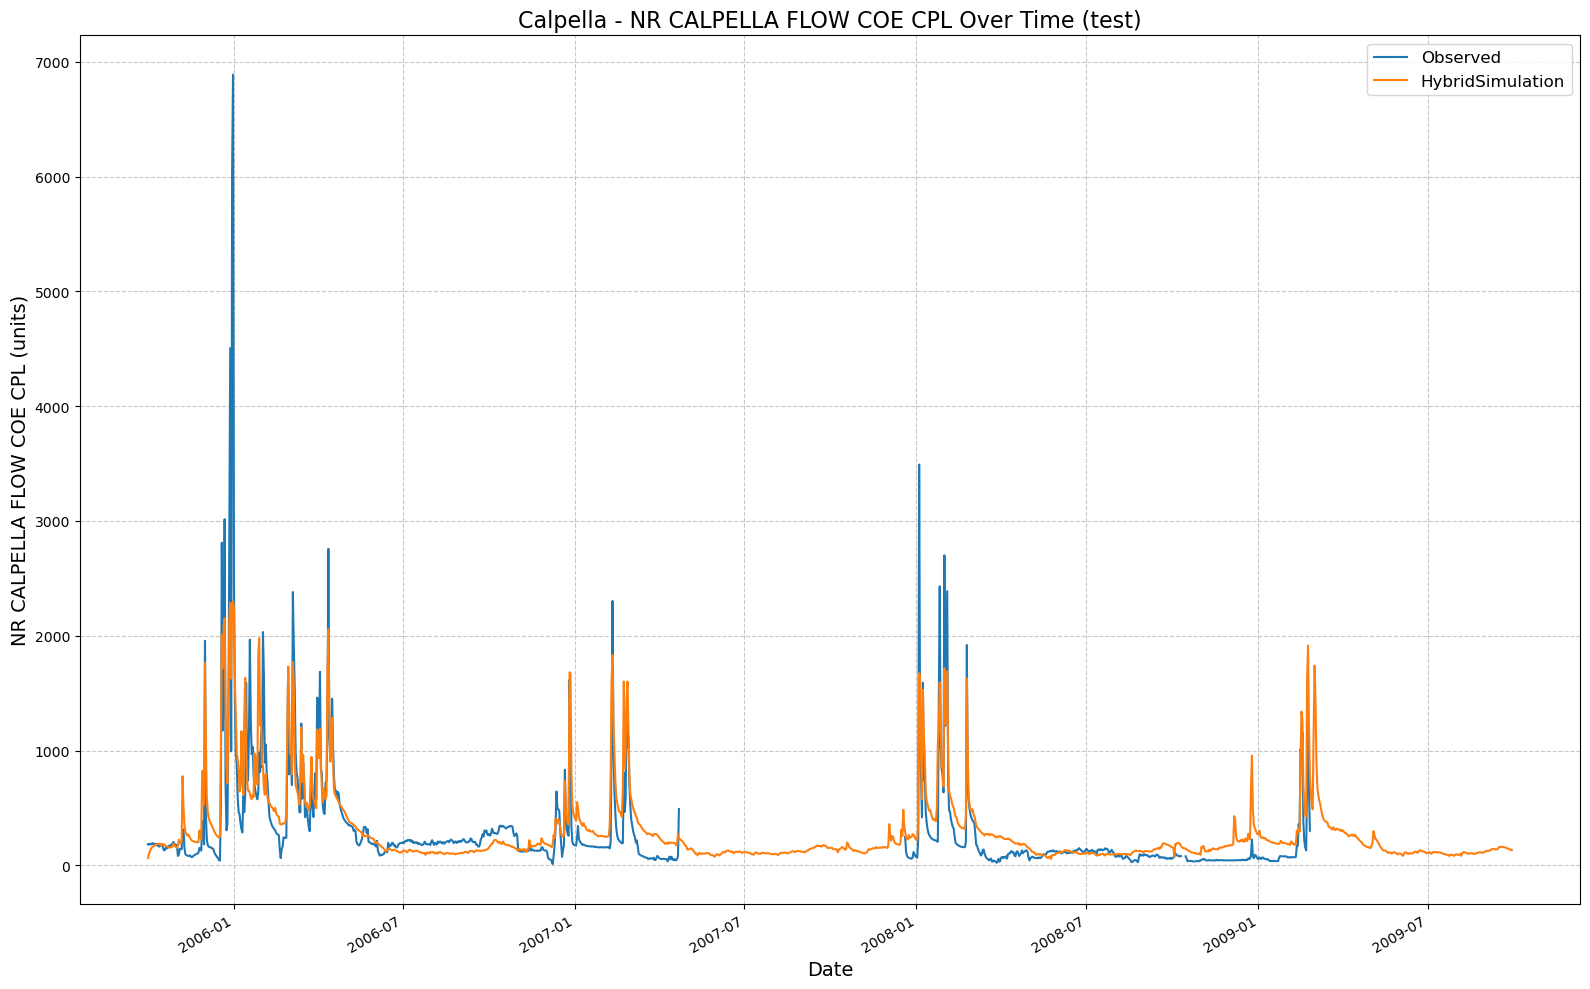

In [22]:
if not skip_best_model_test:
    lstmPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
    )
    
    lstmPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = lstmPhysicsExtBest.results('test')
    physics_test_metrics

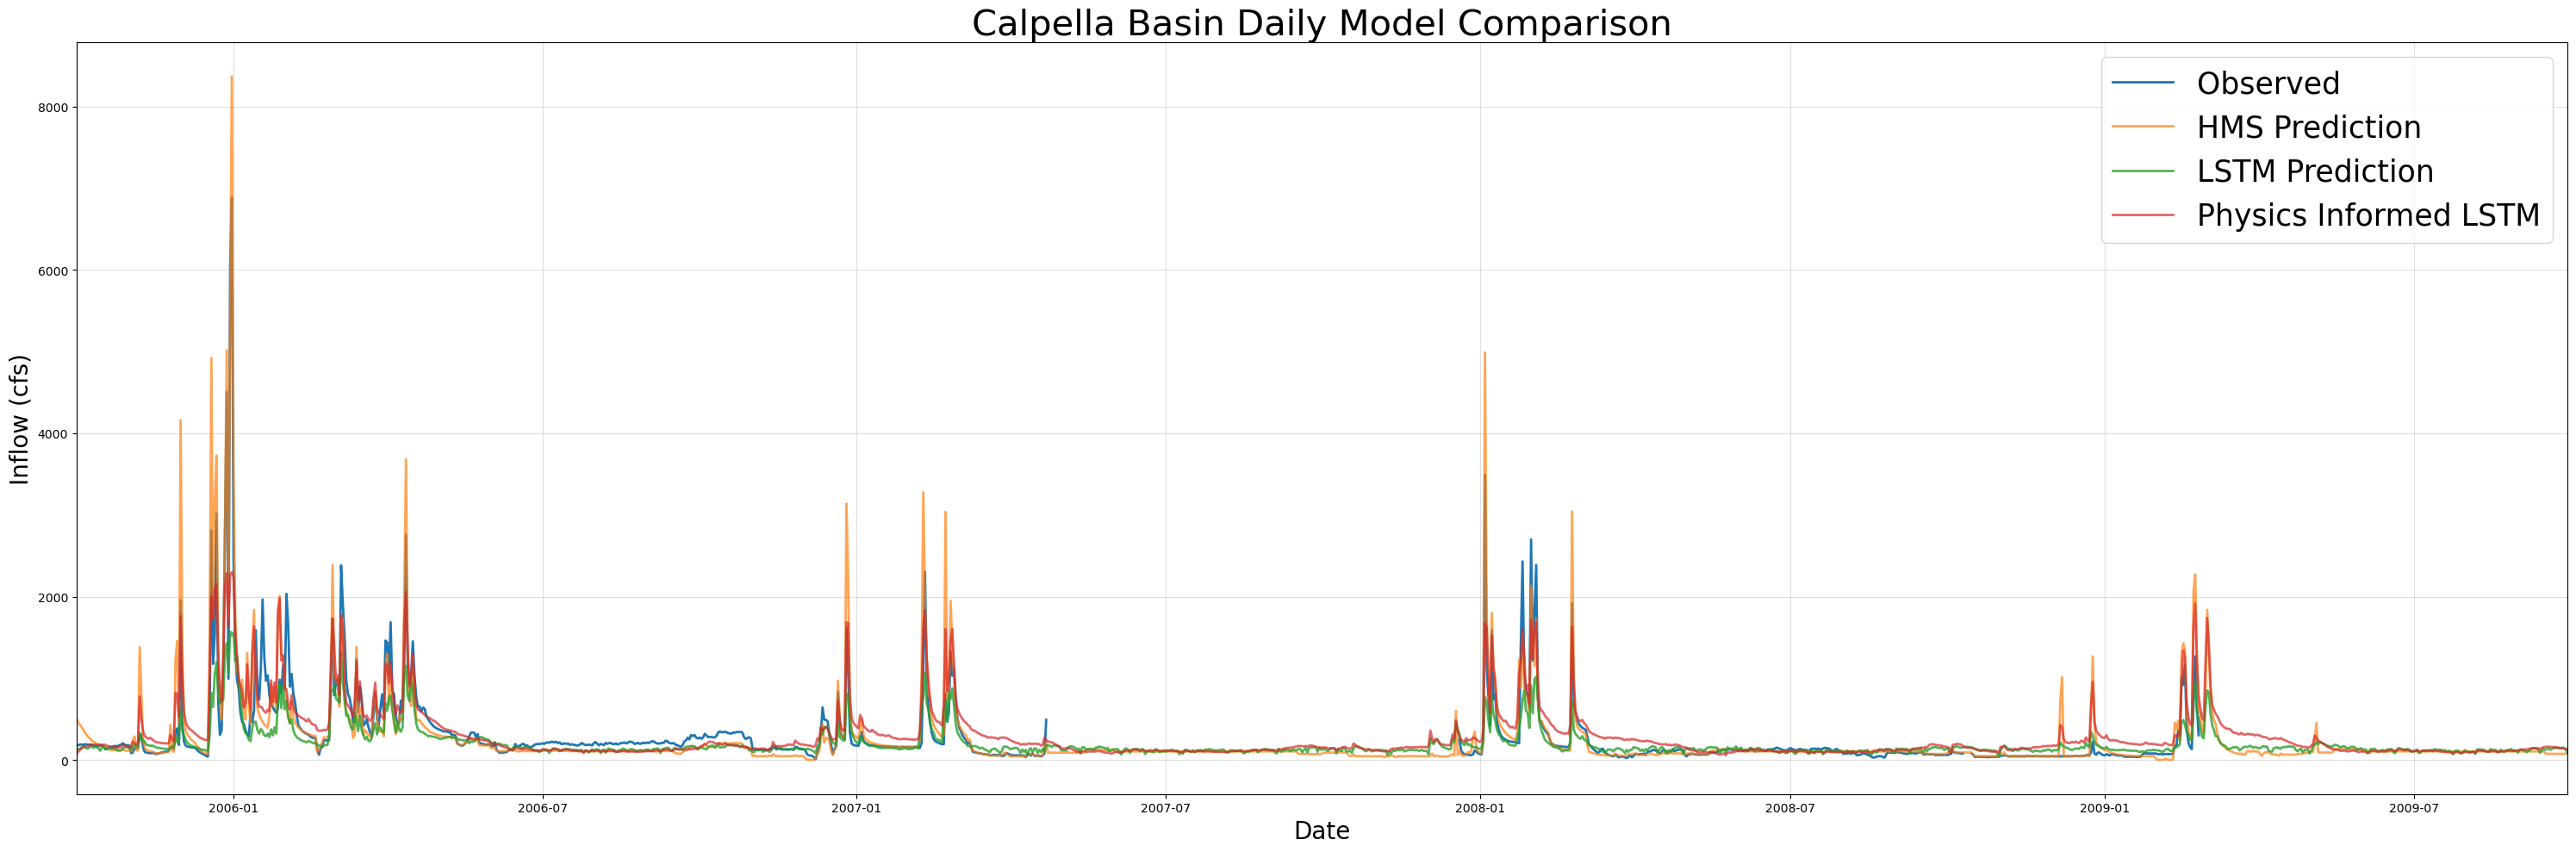

In [23]:
if not skip_best_model_test:
    combinedPlot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title='Calpella Basin Daily Model Comparison',
        fName = "calpella_daily_test_metrics.csv",
        plot_filename="calpella_daily_test_model_comparison.png",
        timeseries_filename ="calpella_daily_test_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("calpella_daily_test_combined_ts.csv")
    combinedPlotFromDf(combined_df, title='Calpella Basin Daily Model Comparison', fName = "calpella_daily_test_metrics.csv")

In [24]:
if not skip_best_model_test:
    fancyCombinedPlot(lstm_results=no_physics_test_csv, lstmPhysics_results= physics_test_csv, HMS_results=path_to_physics_data, title='Calpella Basin Daily Model Comparison', fName = "calpella_daily_test_metrics.csv", timeseries_filename ="calpella_daily_test_combined_ts.csv")
else:
    fancyCombinedPlotFromDf(combined_df, title='Calpella Basin Daily Model Comparison', fName = "calpella_daily_test_metrics.csv")

In [25]:
# if skip_best_model_train:
test_metrics = pd.read_csv("calpella_daily_test_metrics.csv", index_col=0)
print(test_metrics)

                      HMS           LSTM  Physics_Informed_LSTM
NSE              0.699185       0.508843               0.656687
MSE          76611.391217  125087.715765           87434.880522
RMSE           276.787628     353.677418             295.693897
KGE              0.746423       0.348386               0.638192
Alpha-NSE        1.224704       0.414758               0.751105
Beta-KGE         1.058860       0.759058               1.192317
Beta-NSE         0.034578      -0.141542               0.112977
Pearson-r        0.898291       0.844952               0.821196
FHV             25.593699     -59.721456             -33.195088
FMS              0.630349     -41.712334              -9.154330
FLV           -969.540579      30.968816              57.754789
Peak-Timing      0.000000       0.250000               0.000000
Peak-MAPE       54.234115      57.970784              39.808976
PBIAS           -5.886041      24.094185             -19.231650


In [26]:
end_time = datetime.utcnow()
print("\nEnd time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)


End time: 2025-06-19 01:14:52
Total time: 0:00:33.731957


C:\Users\arman\AppData\Local\Temp\ipykernel_30576\3925244319.py:1: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

